# Imports and Other Settings

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True))
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 980, pci bus id: 0000:26:00.0, compute capability: 5.2
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



# Get The Data

In [2]:
def get_split_and_shuffle_the_data(name, url, train_size, val_size, shuffles, column_names):
    '''
    It downloads data from given URL, read it
    shuffles it and split into training and validation sets
    :param name: name of the file to download
    :param url: url addressl which is used to download data
    :param train_size: percentage of downloaded data,
     which will be used as training data
    :param val_size: percentage of downloaded data,
     which will be used as validation data
    :return: training dataset, validation dataset,
     training labels, validation labels
    '''
    # read the data
    raw_dataset_path = tf.keras.utils.get_file(name, url)
    raw_dataset = pd.read_csv(raw_dataset_path, names=column_names, header=0).sample(frac=1).reset_index(drop=True)
    raw_labels = raw_dataset.pop(column_names[-1])
    
    # split the data
    dataset_size = raw_dataset.shape[0]
   
    train_size = int(train_size / 100 * dataset_size)
    val_size = int(val_size / 100 * dataset_size)
    train_data = raw_dataset[:train_size]
    val_data = raw_dataset[train_size:train_size + val_size]
    train_labels = raw_labels[:train_size]
    val_labels = raw_labels[train_size:train_size + val_size]
    
    return train_data, val_data, train_labels, val_labels

def replace_labels(dataset, from_label):
    '''
    Sometimes dataset from Internet contains labels that 
    are strings. Integers are necessary, so this function
    changes these labels into numbers
    :param dataset: dataset - labels to replace string content
    :param from_label: given labels to replace - we have to know
     what to replace
    :return: new dataset - labels with integer labels
    '''
    to_label = tf.range(len(from_label))
    new_dataset = dataset
    for ii in range(len(from_label)):
        new_dataset[new_dataset == from_label[ii]] = to_label[ii]
    new_dataset = new_dataset.astype("int64")
    return new_dataset

In [3]:
NAME = "iris.data"
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
TRAIN_SIZE = 80
VAL_SIZE = 20
SHUFFLES = 1000
COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']

train_data, val_data, train_labels, val_labels = get_split_and_shuffle_the_data(
    NAME, URL, TRAIN_SIZE, VAL_SIZE, SHUFFLES, COLUMN_NAMES)

train_labels = replace_labels(train_labels, ["Iris-setosa", "Iris-versicolor", "Iris-virginica"])
val_labels = replace_labels(val_labels, ["Iris-setosa", "Iris-versicolor", "Iris-virginica"])

## DNNClassifier ▶

In [4]:
def provide_input_data_as_minibatches(features, labels, batch_size, training):
    '''
    Function that will return data as batches for dnnclassifier
    :param features: data to learn on / validate on / test on
    :param labels: just labels
    :param batch_size: size of the batch
    :param training: if this is trainig, then dataset
     have to be shuffled enough
    :return: dataset into batches
    '''
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    if training:
        dataset = dataset.shuffle(1000).repeat()
    return dataset.batch(batch_size)

def get_the_features(dataset):
    '''
    Extract features from given dataset
    :param features: given dataset
    :return: list of features
    '''
    return [tf.feature_column.numeric_column(key=key) for key in dataset.keys()]

def create_dnnclassifier(layers_list, classes):
    '''
    DNNClassifier generator
    :param layers_list: list of all layers density/size
    :param classes: number of classes / unique labels
    :return: dnnclassifier
    '''
    feature_columns = get_the_features(train_data)
    classifier = tf.estimator.DNNClassifier(
        feature_columns=feature_columns,
        hidden_units=layers_list,
        n_classes=classes,
        model_dir='./logs/dnnclassifier')
    return classifier

def train_dnnclassifier(classifier, input_fn, train_data, train_labels, batch_size, steps):
    '''
    This function calls DNNCLassifier training - lerning
    :param classifier: given dnnclassifier
    :param input_fn: given function, that returns data as batches
    :param train_data: given training data
    :param train_labels: given training labels
    :param batch_size: size of the batch
    :param steps: number of steps for algorithm
    '''
    classifier.train(
    input_fn=lambda: input_fn(train_data, train_labels, batch_size, True),
    steps=steps)
    
def evaluate_dnnclassifier(classifier, input_fn, val_data, val_labels, batch_size):
    '''
    This function calls DNNCLassifier evaluation - checking
    :param classifier: given dnnclassifier
    :param input_fn: given function, that returns data as batches
    :param val_data: given validation data
    :param val_labels: given validation labels
    :param batch_size: size of the batch
    :return: results of evaluation (loss, accuracy)
    '''
    result = classifier.evaluate(input_fn=lambda: input_fn(train_data, train_labels, batch_size, False))
    return result

In [5]:
LAYERS = [30,10]
CLASSES = 3
BATCH_SIZE = 32
STEPS = 5000 
classifier = create_dnnclassifier(LAYERS, CLASSES)
train_dnnclassifier(classifier, provide_input_data_as_minibatches, train_data, train_labels, BATCH_SIZE, STEPS)

In [6]:
result = evaluate_dnnclassifier(classifier, provide_input_data_as_minibatches, val_data, val_labels, BATCH_SIZE)
print('\Eval set accuracy: {accuracy:0.3f}\n'.format(**result))

\Eval set accuracy: 0.950



## As Simple As Possible Neural Network ▶

In [7]:
tensorboard = TensorBoard(log_dir="logs/{}".format("As Simple As Possible Neural Network"))
asap_nn = keras.Sequential([
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

In [8]:
asap_nn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
asap_nn.fit(train_data, train_labels, epochs=15, batch_size=32, callbacks=[tensorboard], verbose=0)  

In [10]:
eval_loss, eval_acc = asap_nn.evaluate(val_data, val_labels, verbose=0)
print("Eval set accuracy: {0:0.3f}".format(eval_acc))

Eval set accuracy: 1.000


## Interactive Predictions

In [11]:
features = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']
spieces =  ["Iris Setosa", "Iris Versicolor", "Iris Virginica"]
columns = ['SepalLength' , 'SepalWidth', 'PetalLength', 'PetalWidth']
my_features = [-1]*len(features)

def predict(model):
    '''
    This function asks user for 4 different features of Irises,
    and then tries to predict label for such dataset by using given model
    :param classifier: model to predict on
    '''
    for ii in range(len(features)):
        buf = float(input(f"{features[ii]}: "))
        my_features[ii] = buf
    feats = tuple(i for i in my_features)
    feats_list = list()
    feats_list.append(feats)
    res = model.predict(pd.DataFrame(feats_list, columns = columns))
    print("This Iris is probably:{0:} {1:0.5f}%".format(spieces[np.argmax(res)], np.max(res)))

In [12]:
predict(asap_nn)

Sepal Length: 5
Sepal Width: 2
Petal Length: 1
Petal Width: 0
This Iris is probably:Iris Setosa 0.94448%


## Models Comparison 

In [13]:
def display_loss(loss, linestyle, i, bottom_tittle, top_tittle):
    '''
    Displays loss values for each model
    :param loss: dataset to display
    :param linestyle: color and style of the line
    :param i: number of plot's positioin at figure
    :param bottom_tittle: x axis tittle
    :param top_tittle: plot's tittle 
    '''
    x = loss.values[:,1]
    y = loss.values[:,2]
    x_min = 0
    if np.max(x)>1000:
        x_max = int(np.ceil(np.max(x) / 1000.0) * 1000)
    elif np.max(x)>100:
        x_max = int(np.ceil(np.max(x) / 100.0) * 100)
    elif np.max(x)>10:
        x_max = int(np.ceil(np.max(x) / 10.0) * 10)
    else:
        x_max = int(np.ceil(np.max(x)))
    y_min = 0
    y_max = 1
    sub = fig.add_subplot(1, 2, i)
    plt.xlabel(bottom_tittle, fontsize=10)
    plt.ylabel("Loss", fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    sub.set_xlim(x_min, x_max)
    sub.set_ylim(y_min, y_max)
    sub.set_title(top_tittle)
    sub.plot(x, y, linestyle)
    sub.grid()

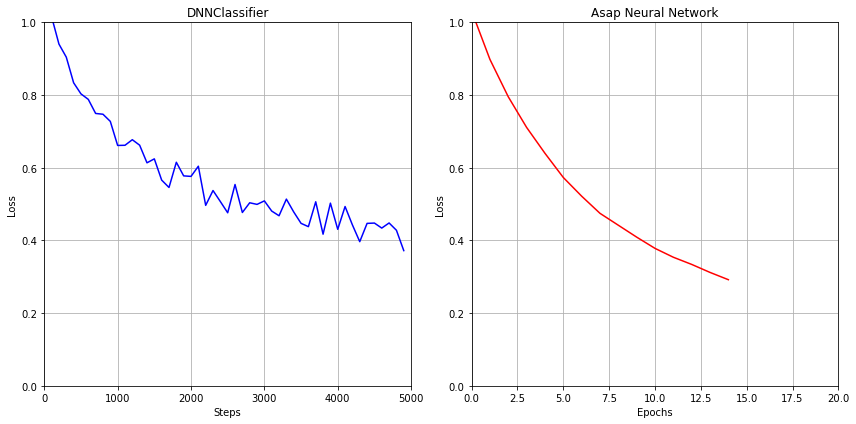

In [14]:
dnnclassifier_loss = raw_dataset = pd.read_csv("logs/dnnclassifier_loss.csv")
asap_epoch_loss = raw_dataset = pd.read_csv("logs/asap_epoch_loss.csv")
fig = plt.figure(figsize=(12, 6))
display_loss(dnnclassifier_loss, '-b', 1, "Steps", "DNNClassifier")
display_loss(asap_epoch_loss, '-r', 2, "Epochs", "Asap Neural Network")
plt.tight_layout()
plt.draw()